The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [1]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.datasets import make_moons
from homegrad.nn import Module
from homegrad.nn import Neuron
from homegrad.nn import Layer
from homegrad.nn import MLPerceptron
from homegrad.engine import * 
from homegrad.drawer import * 

%matplotlib inline

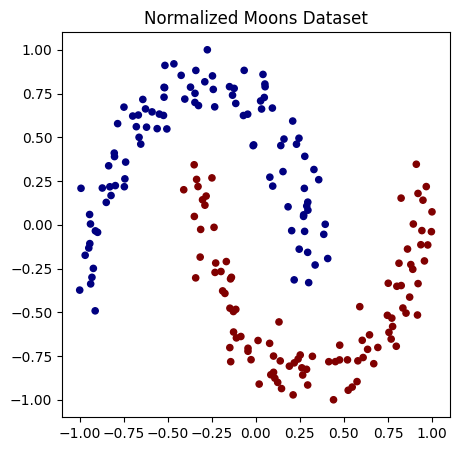

In [17]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 200, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# Min-max normalization for X between -1 and 1
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = 2 * (X - X_min) / (X_max - X_min) - 1

# Visualize normalized data in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=y, s=20, cmap='jet')
plt.title("Normalized Moons Dataset")
plt.show()

In [18]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(200, 2)


In [14]:
#creating an instance of our homemade MLP class with 2 input neurons, a layer with 5 neurons, and another layer with 3 neurons, with 1 output neuron
#n = MLPerceptron(2,[16,16,1])


In [15]:
#for k in range(20):
#    #Forward pass
#    ypred = [n(x) for x in X]
#    loss = sum(((yout - ygt)**2 for ygt,yout in zip(y,ypred)),Value(0))
#    #Now we do the backward pass
#    for p in n.parameters():
#        p.grad = 0.0
#    loss.backward()

#    #Update. now we do gradient descent
#    ##Changing the data of each of our parameters depending on the gradient they have on the loss function. Gradient descent! 
#    for p in n.parameters():
#        p.data += -0.05 * p.grad
#    print(k,loss.data) 

In [19]:
##Ok this absolutely did not work. Let's try this again, but actually think about it this time. First of all, we should be doing batching. 
#Second of all, using MSE for this is a bit silly. Let's try hinge loss. 

#print(MLPerceptron.__init__.__code__.co_varnames)
n = MLPerceptron(2,[8,8,1], activations = ['tanh', 'tanh' ])
print(n.activations)



['tanh', 'tanh', 'none']


In [80]:
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(n, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in n.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)



total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.103927626197718, grad=0) 0.305


In [20]:
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(n, inputs))
    
    # SVM "max-margin" hinge loss
    losses = [Value(max(0, 1 - yi * scorei.data)) for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in n.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    accuracy = sum(accuracy) / len(accuracy)
    
    return total_loss, accuracy

# Evaluate loss and accuracy
total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.1148151291389454, grad=0) 0.335


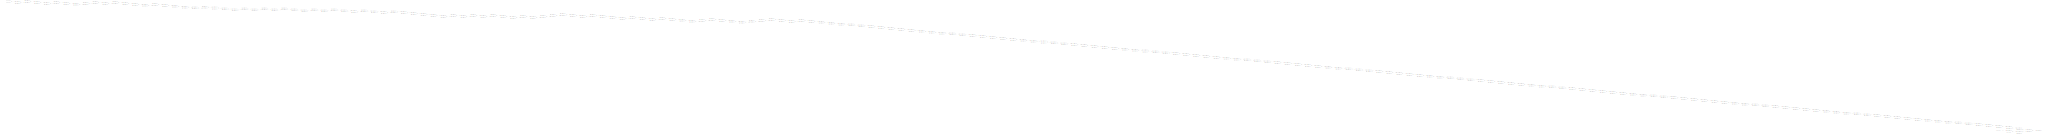

In [21]:
draw_dot(total_loss)

In [15]:
#draw_dot(n((0.5,0.5)))

In [25]:
# optimization

def optimize(iters):
    for k in range(iters):
        # forward
        total_loss, acc = loss(32)
        
        # Check connectivity
        print(f"Loss _prev set: {total_loss._prev}")
        
        # backward
        n.zero_grad()
        total_loss.backward()
        
        # Check gradients immediately after backward
        params = list(n.parameters())
        print(f"Gradients after backward: {[p.grad for p in params[:5]]}")
        
        # update (sgd)
        learning_rate = 0.001
        for p in n.parameters():
            p.data -= learning_rate * p.grad
        
        if k % 1 == 0:
            print(f"step {k+1} loss {total_loss.data}, accuracy {acc*100}%")
        
        # Check gradients at end of iteration
        print(f"Gradients at end of iteration: {[p.grad for p in params[:5]]}")

optimize(100)

Loss _prev set: {Value(data=0.00257643438229212, grad=0), Value(data=1.0014850990828694, grad=0)}
Gradients after backward: [0, 0, 0, 0, 0]
step 1 loss 1.0040615334651615, accuracy 40.625%
Gradients at end of iteration: [0, 0, 0, 0, 0]
Loss _prev set: {Value(data=0.00257643438229212, grad=0), Value(data=1.062632009798051, grad=0)}
Gradients after backward: [0, 0, 0, 0, 0]
step 2 loss 1.065208444180343, accuracy 40.625%
Gradients at end of iteration: [0, 0, 0, 0, 0]
Loss _prev set: {Value(data=0.00257643438229212, grad=0), Value(data=1.0413797275631993, grad=0)}
Gradients after backward: [0, 0, 0, 0, 0]
step 3 loss 1.0439561619454913, accuracy 40.625%
Gradients at end of iteration: [0, 0, 0, 0, 0]
Loss _prev set: {Value(data=1.2170352424874846, grad=0), Value(data=0.00257643438229212, grad=0)}
Gradients after backward: [0, 0, 0, 0, 0]
step 4 loss 1.2196116768697767, accuracy 21.875%
Gradients at end of iteration: [0, 0, 0, 0, 0]
Loss _prev set: {Value(data=0.00257643438229212, grad=0), 

In [99]:
#testing
print(n.layers[0].neurons[3].w[0].grad)

0


(-1.5898746336049419, 2.160125366395058)

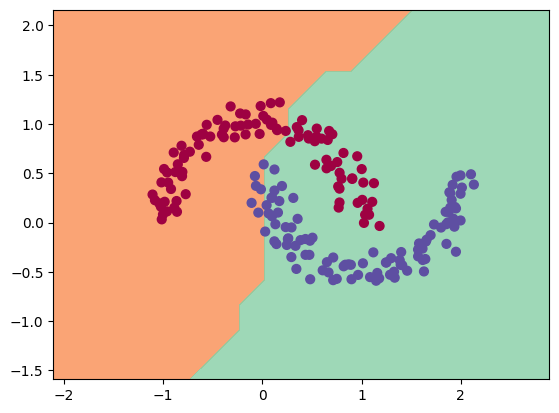

In [85]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(n, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())